### import the libraries

In [263]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from matplotlib.ticker import ScalarFormatter, NullFormatter # for log ticks
from scipy.optimize import curve_fit # for bass model

### generate random networks

In [230]:
def generate_random_graph(G=None, nodes=None, edges=None, random_type="ER"):
    if G is not None:
        n = G.number_of_nodes()
        m = G.number_of_edges()
    else:
        n = nodes
        m = edges
    
    if random_type == "ER":
        # Erdös Renyi random graph
        g_ran = nx.gnm_random_graph(n=n, m=m, directed=False)
    elif random_type == "WS":
        # Watts Strogatz random graph: rewiring with p = 0.01: high clustering and low diameter
        g_ran = nx.watts_strogatz_graph(n=n, k=int(m/n), p=0.01) 
    elif random_type == "BA":
        # Barabasi Albert random graph
        g_ran = nx.barabasi_albert_graph(n=n, m=int(m/n))
    elif random_type == "KB":
        # Kleinberg model random graph
        lattice_length = math.ceil(math.sqrt(n))
        g_ran = nx.navigable_small_world_graph(n=lattice_length, p=1, q=1, r=10, dim=2)
    elif random_type == "newman_WS":
        g_ran = nx.newman_watts_strogatz_graph(n=n, k=int((m) / n * 2), p=0.01)
    else:
        print("please specify one of ER / WS / BA / KB")
        return
    g_ran = g_ran.to_undirected()
    return(g_ran)

### show properties of a graph

In [80]:
def show_prop(G):
    # normal graph properties
    print(f'Number of nodes: {G.number_of_nodes()}')
    print(f'Number of edges: {G.number_of_edges()}')
    if nx.is_connected(G):
        print(f'Clustering coefficient: {nx.transitivity(G)}')
        print(f'Diameter: {nx.diameter(G)}')
        print(f'Average path length: {nx.average_shortest_path_length(G)}')
        print(f'Graph density: {nx.density(G)}')

    # draw degree rank plot
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    
    fig, ax = plt.subplots()

    ax.loglog(degrees, degree_freq,'go-')
    ax.set_title("Degree Distribution (Log-Log Scale)")
    ax.set_ylabel('Degree')
    ax.set_xlabel('Frequency')
    ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())

    fig.tight_layout()
    plt.show()

### method for spread of information

In [126]:
def spread_of_information(G, T, initial_adopt, type):
    G = G
    n = len(G.nodes())
    print(n)
    initial_adopt_num = int(initial_adopt * n)
    #print(initial_adopt_num)

    # sort the nodes by degree
    node_and_degree = G.degree()
    (node, degree) = zip(*node_and_degree)
    sorted_deg = [x for (y,x) in sorted(zip(degree,node), reverse=True)]

    # get the page rank of the nodes with dumping factor 0.85
    pr = nx.pagerank(G, alpha=0.85)

    # sort the nodes by page rank
    sorted_pr = sorted(pr, key=pr.get, reverse=True)

    #print(sorted_pr)


    # add status & threshold attribute to nodes
    for node in G.nodes():
        G.nodes[node]['status'] = 0
        G.nodes[node]['threshold'] = random.random()

    # set initial adopters
    if type == 'central':
        for node in sorted_deg[:initial_adopt_num]:
            G.nodes[node]['status'] = 1
    elif type == 'marginal':
        for node in sorted_deg[-(initial_adopt_num)]:
            G.nodes[node]['status'] = 1
    else:
        for i in range(initial_adopt_num):
            node = random.choice(list(G.nodes()))
            G.nodes[node]['status'] = 1

    # spread of information

    T = T
    # if node does not have status 1 then calculate the perentage of it's neighbors that have status 1 and save that in the node attributes
    number_of_adopters = [initial_adopt_num]
    for i in range(T):
        # if full diffusion happened stop the process
        if i != 0 and number_of_adopters[-1] == n:
            number_of_adopters += [n] * (T - len(number_of_adopters))
            print(f'Diffusion already stopped at time step: {i+1}')
            # break out of the outest for loop
            break 
        for node in G.nodes():
            if G.nodes[node]['status'] == 0:
                neighbors = list(G.neighbors(node))
                count = 0
                for neighbor in neighbors:
                    if G.nodes[neighbor]['status'] == 1:
                        count += 1
                percentage = count/len(neighbors)
                G.nodes[node]['percentage_adopt'] = percentage

                # calculate the probability of adoption by taking the mean of perenctage and threshold, and save it as attribute
                if G.nodes[node]['percentage_adopt'] == 0:
                    G.nodes[node]['probability'] = 0
                else:
                    G.nodes[node]['probability'] = (G.nodes[node]['percentage_adopt'] + G.nodes[node]['threshold'])/2

                # flip a coin to update the status of the node
                if random.random() < G.nodes[node]['probability']:
                    G.nodes[node]['status'] = 1

        # get the list of nodes with status 1
        adopters = [node for node in G.nodes() if G.nodes[node]['status'] == 1]
        number_of_adopters.append(len(adopters))

    return number_of_adopters

### Graph Preprocessing

In [264]:
# Create a graph from edge list
G = nx.read_edgelist('data/politician_edges.csv', delimiter=',')

def graph_preprocessing(G):
    # make graph undirected
    G = G.to_undirected()
    
    # remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # remove disconnected components
    if not nx.is_connected(G):
        components = [a for a in nx.connected_components(G)]
        if len(components) > 1:
            biggest_component = len(components[0])
            for c in components[1:]:
                if len(c) > biggest_component:
                    biggest_component = len(c)
            for c in components:
                if len(c) != biggest_component:
                    for node in c:
                        G.remove_node(node)
        assert nx.is_connected(G)
    return G

G = graph_preprocessing(G)

### averaging function

In [129]:
def make_diffusion_and_average(simulations, G, T, initial_adopt, type):
    cumulated_diffusion_list = list()
    for i in range(simulations):
        diff = spread_of_information(G, T, initial_adopt, type)
        if i==0:
            # initialize with values first
            cumulated_diffusion_list = diff
        else:
            # add new diff to cumulated diff
            cumulated_diffusion_list = [sum(x) for x in zip(cumulated_diffusion_list, diff)]
    averaged_diffusion_list = [x / simulations for x in cumulated_diffusion_list]
    print("All simulations completed!")
    return averaged_diffusion_list

### execution

5908
Diffusion already stopped at time step: 18
5908
Diffusion already stopped at time step: 22
5908
Diffusion already stopped at time step: 20


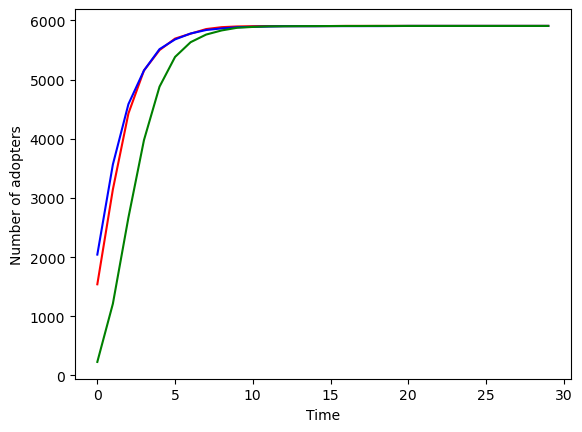

In [118]:
ran = spread_of_information(G, 30, 0.025, 'random')
cen = spread_of_information(G, 30, 0.025, 'central')
mar = spread_of_information(G, 30, 0.025, 'marginal')

# plot the number of adopters over time
plt.plot(ran, label='random', color='red')
plt.plot(cen, label='central', color='blue')
plt.plot(mar, label='marginal', color='green')
plt.xlabel('Time')
plt.ylabel('Number of adopters')
plt.show()

In [ ]:
ran = make_diffusion_and_average(5, G, 30, 0.025, 'random')
cen = make_diffusion_and_average(5, G, 30, 0.025, 'central')
mar = make_diffusion_and_average(5, G, 30, 0.025, 'marginal')

# plot the number of adopters over time
plt.plot(ran, label='random', color='red')
plt.plot(cen, label='central', color='blue')
plt.plot(mar, label='marginal', color='green')
plt.xlabel('Time')
plt.ylabel('Number of adopters')
plt.show()

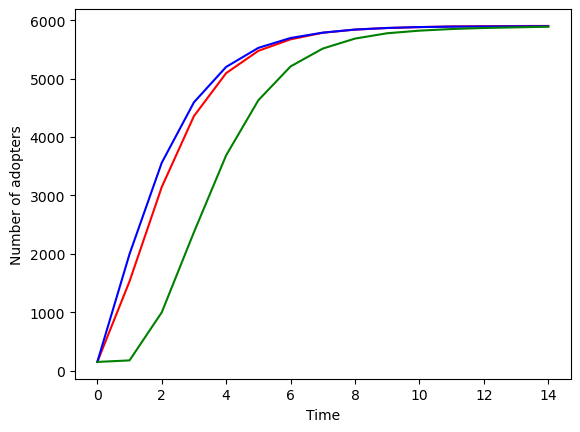

In [128]:
# plot the number of adopters over time
plt.plot(ran[:15], label='random', color='red')
plt.plot(cen[:15], label='central', color='blue')
plt.plot(mar[:15], label='marginal', color='green')
plt.xlabel('Time')
plt.ylabel('Number of adopters')
plt.show()

### the plot with all graph types and same cetrality measure

In [232]:
# random networks
G_ER = generate_random_graph(G, random_type="ER")
ER_cen = make_diffusion_and_average(5, G_ER, 30, 0.025, 'central')
G_WS = generate_random_graph(G, random_type="WS")
WS_cen = make_diffusion_and_average(5, G_WS, 30, 0.025, 'central')
G_BA = generate_random_graph(G, random_type="BA")
BA_cen = make_diffusion_and_average(5, G_BA, 30, 0.025, 'central')
G_KB = generate_random_graph(G, random_type="newman_WS")
KB_cen = make_diffusion_and_average(5, G_KB, 30, 0.025, 'central')
#real network
cen = make_diffusion_and_average(5, G, 30, 0.025, 'central')

5910
Diffusion already stopped at time step: 15
5910
Diffusion already stopped at time step: 12
5910
Diffusion already stopped at time step: 12
5910
Diffusion already stopped at time step: 13
5910
Diffusion already stopped at time step: 14
All simulations completed!
5910
Diffusion already stopped at time step: 27
5910
Diffusion already stopped at time step: 24
5910
Diffusion already stopped at time step: 25
5910
5910
Diffusion already stopped at time step: 22
All simulations completed!
5910
Diffusion already stopped at time step: 11
5910
Diffusion already stopped at time step: 13
5910
Diffusion already stopped at time step: 11
5910
Diffusion already stopped at time step: 10
5910
Diffusion already stopped at time step: 14
All simulations completed!
5910
Diffusion already stopped at time step: 13
5910
Diffusion already stopped at time step: 12
5910
Diffusion already stopped at time step: 16
5910
Diffusion already stopped at time step: 15
5910
Diffusion already stopped at time step: 16
Al

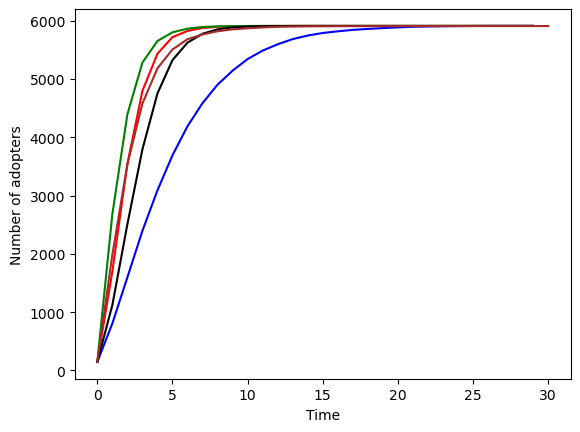

In [233]:
# plot the number of adopters over time
plt.plot(ER_cen, label='ER-cen', color='red')
plt.plot(WS_cen, label='WS_cen', color='blue')
plt.plot(BA_cen, label='BA_cen', color='green')
plt.plot(KB_cen, label='KB_cen', color='black')
plt.plot(cen, label='cen', color='brown')
plt.xlabel('Time')
plt.ylabel('Number of adopters')
plt.show()

### Bass model

In [265]:
def fit_bass_model(function, xdata, ydata):
    def c_t(x, p, q, m):
        return (p+(q/m)*(x))*(m-x)
    popt, pcov = curve_fit(c_t, range(len(cen_mod)), cen_mod)
    return popt, pcov

In [268]:
def fit_bass_model(xdata, ydata):
    """fits the bass model on given xdata and ydata"""
    def c_t(x, p, q, m):
        return (p+(q/m)*(x))*(m-x)
    popt, pcov = curve_fit(c_t, range(len(cen_mod)), cen_mod)
    p, q, m = popt[0], popt[1], popt[2]
    return c_t(xdata, p, q, m)

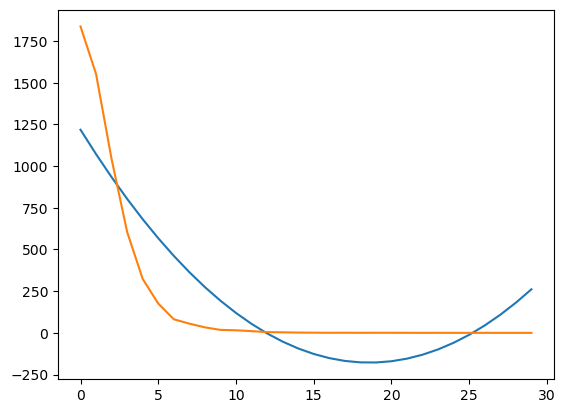

In [271]:
plt.plot(fit_bass_model(range(len(cen_mod)), cen_mod))
plt.plot(cen_mod)

In [266]:
cen_mod = [cen[i+1]-cen[i] for i in range(len(cen)-1)]
popt, pcov = fit_bass_model(c_t, range(len(cen_mod)), cen_mod)

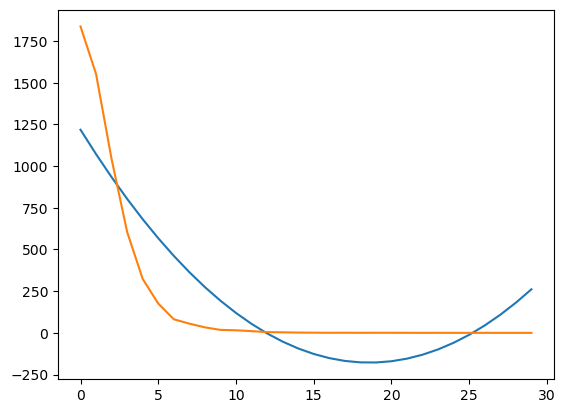

In [267]:
plt.plot(c_t(range(len(cen_mod)), popt[0], popt[1], popt[2]))
plt.plot(cen_mod)

# Test area

### newman WS

In [227]:
wanted = 5400
t = int((5400) / 1000 * 2)
print(t)

G_N = nx.newman_watts_strogatz_graph(1000, t+2, 0)
# Check the number of nodes and edges
print(f'Number of nodes: {G_N.number_of_nodes()}')
print(f'Number of edges: {G_N.number_of_edges()}')
#print(f'Clustering coefiicient: {nx.transitivity(G_KL)}')
#print(f'Diameter: {nx.diameter(G_KL)}')

#nx.draw(G_N)

10
Number of nodes: 1000
Number of edges: 6000


### kleinberg model

176
Number of nodes: 16
Number of edges: 116
7500


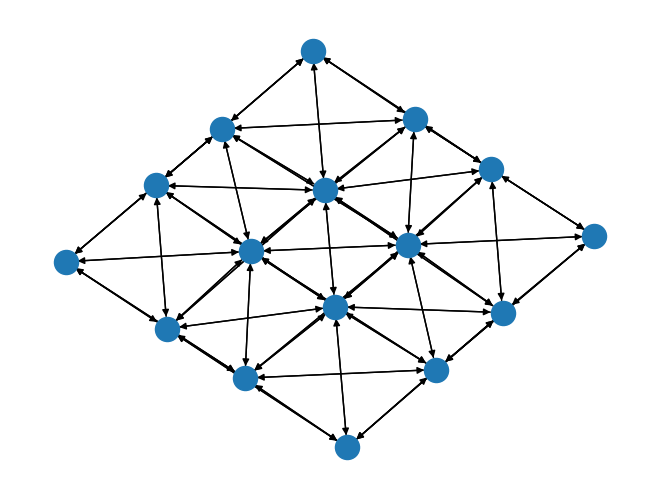

In [141]:
# Seed the random number generator for reproducibility

# Generate the graph
G_KL = nx.navigable_small_world_graph(4, p=2, q=0, r=10, dim=2)
G = G_KL.to_undirected()

# Check the number of nodes and edges
print(f'Number of nodes: {G_KL.number_of_nodes()}')
print(f'Number of edges: {G_KL.number_of_edges()}')
#print(f'Clustering coefiicient: {nx.transitivity(G_KL)}')
#print(f'Diameter: {nx.diameter(G_KL)}')

nx.draw(G_KL)

In [157]:
lattice_length = 10
wanted = 500
for i in range(lattice_length-1):
    print((lattice_length-1)*lattice_length*2)
    if (lattice_length-1)*lattice_length*2+(lattice_length^2)*(i+1)*4 < wanted:
        continue
    else:
        print(i)
        print((lattice_length-1)*lattice_length*2+(lattice_length^2)*(i+1)*4)

180
180
180
180
180
180
180
180
180


Number of nodes: 10
Number of edges: 39
240


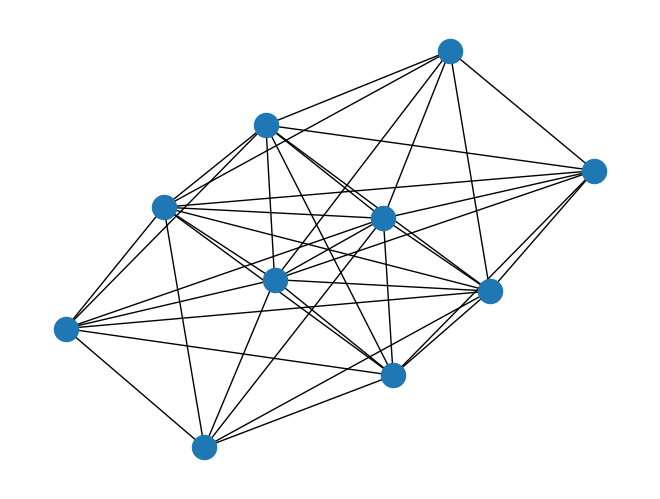

In [198]:
G_KL = nx.navigable_small_world_graph(10, p=6, q=1, r=2, dim=1)
G_KL = G_KL.to_undirected()
G_KL.remove_edges_from(nx.selfloop_edges(G_KL))

# Check the number of nodes and edges
print(f'Number of nodes: {G_KL.number_of_nodes()}')
print(f'Number of edges: {G_KL.number_of_edges()}')
print(2*4*5+5*5*2*4)
nx.draw(G_KL)

0
932
1
964
2
996
3
1028
4
1060
5
1092
6
1124
7
1156
8
1188
176
Number of nodes: 16
Number of edges: 116
7500


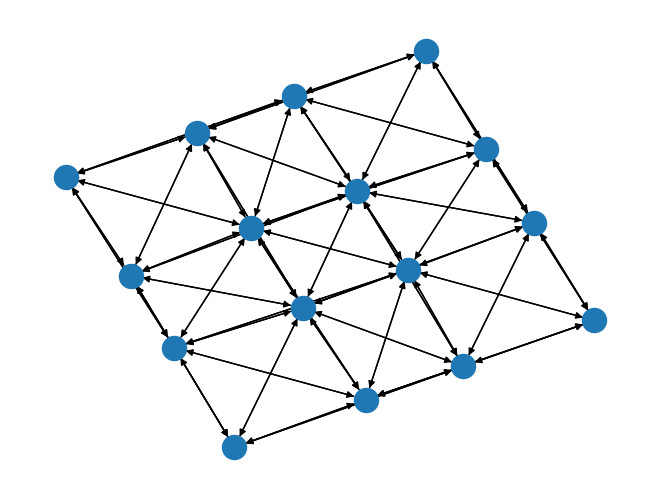

In [189]:
# Seed the random number generator for reproducibility

# Generate the graph
lattice_length = 10
wanted = 500
for i in range(lattice_length-1):
    if (lattice_length-1)*lattice_length*lattice_length+(lattice_length^2)*(i+1)*4 < wanted:
        continue
    else:
        print(i)
        print((lattice_length-1)*lattice_length*lattice_length+(lattice_length^2)*(i+1)*4)
G_KL = nx.navigable_small_world_graph(4, p=2, q=0, r=10, dim=2)
print(3*4*4+16*2*4)
G = G_KL.to_undirected()

# Check the number of nodes and edges
print(f'Number of nodes: {G_KL.number_of_nodes()}')
print(f'Number of edges: {G_KL.number_of_edges()}')
#print(f'Clustering coefiicient: {nx.transitivity(G_KL)}')
#print(f'Diameter: {nx.diameter(G_KL)}')

print(3*50*50)
nx.draw(G_KL)

# Old code

In [ ]:
def show_prop(G):
    # normal graph properties
    print(f'Number of nodes: {G.number_of_nodes()}')
    print(f'Number of edges: {G.number_of_edges()}')
    #print(f'Clustering coefficient: {nx.transitivity(G)}')
    #print(f'Diameter: {nx.diameter(G)}')
    #print(f'Average path lenght: {nx.average_shortest_path_length(G)}')
    #print(f'Graph density: {nx.density(G)}')
    
    # degree sequence
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    
    # maximum degree
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    #draw graph
    #ax0 = fig.add_subplot(axgrid[0:3, :])
    #Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    #pos = nx.spring_layout(Gcc, seed=10396953)
    #nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    #nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    #ax0.set_title("Connected components of G")
    #ax0.set_axis_off()

    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    
    fig1, ax1 = plt.subplots()
    
    # draw degree rank plot

    ax1.loglog(degrees, degree_freq,'go-')
    ax1.set_title("Degree Distribution (Log-Log Scale)")
    ax1.set_ylabel('Degree')
    ax1.set_xlabel('Frequency')
    ax1.xaxis.set_minor_formatter(ScalarFormatter())
    ax1.xaxis.set_minor_formatter(NullFormatter())

    # draw degree histogram
    fig2, ax2 = plt.subplots()
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

G = nx.barabasi_albert_graph(10000, 3)
show_prop(G)